## Загрузка данных и предобработка:

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [4]:
data.rename(columns={'offer': 'treatment', 'conversion': 'target'}, inplace=True)

In [5]:
data ['treatment'] = data['treatment'].replace({'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0})

In [6]:
categories = ['zip_code', 'channel']

In [7]:
X = data.drop(columns=['target', 'treatment'])
y = data['target']
treatment = data['treatment']

In [8]:
X_train, X_test, treat_train, y_test, y_train, treat_test = train_test_split(X, y, treatment, random_state=30, test_size=0.3)

In [9]:
from sklearn.preprocessing import MinMaxScaler
Scaler = MinMaxScaler()

In [10]:
to_standardize = ['recency', 'history']

In [11]:
X_train[to_standardize] = Scaler.fit_transform(X_train[to_standardize])
X_test[to_standardize] = Scaler.transform(X_test[to_standardize])

## SoloModel:

In [12]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier

uplift@10%: 0.0677
uplift@20%: 0.0678


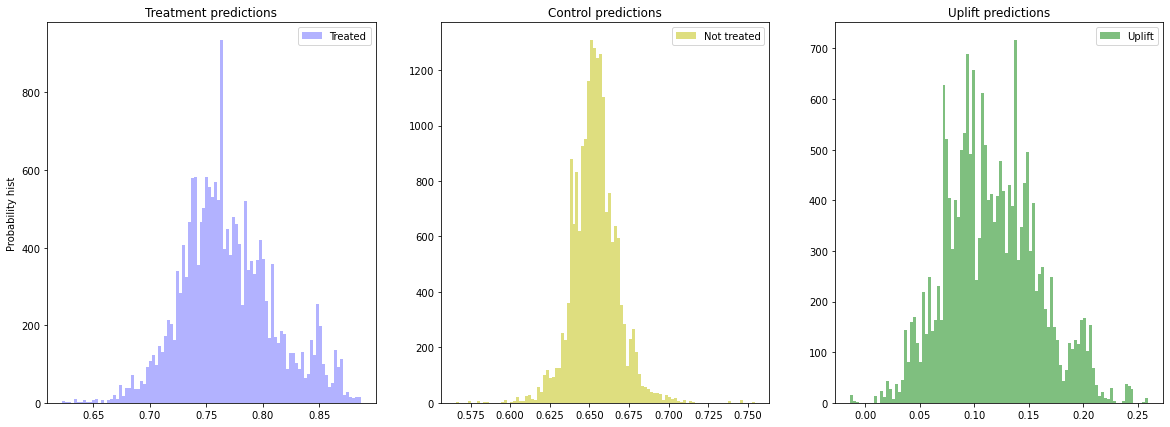

In [13]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': categories})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
print(f'uplift@10%: {sm_score_10:.4f}\nuplift@20%: {sm_score_20:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

## Transformation Model:

In [14]:
from sklift.models import ClassTransformation

ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': categories})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

## Two Models:

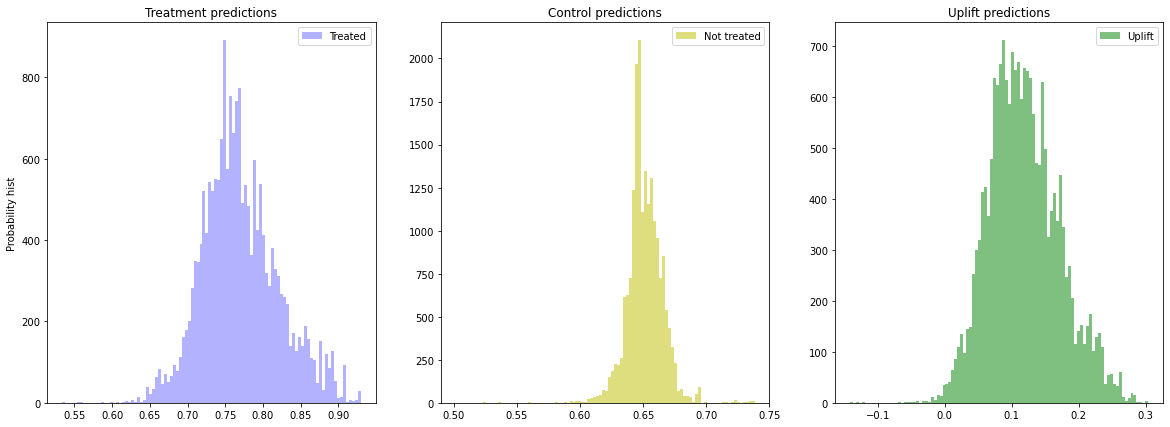

In [15]:
from sklift.models import TwoModels

tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': categories}, 
    estimator_ctrl_fit_params={'cat_features': categories}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

## Сравнение трех моделей:

In [16]:
final_restuls = pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)
final_restuls

,approach,uplift@10%,uplift@20%
1,ClassTransformation,0.092180,0.080680
0,SoloModel,0.067744,0.067752
2,TwoModels,0.041172,0.054059


## Сравнение конверсии для SoloModel:

In [18]:
df = X_test.copy()

In [19]:
df['uplift_sm'] = uplift_sm

In [20]:
df['target'] = y_test

In [21]:
df = df.sort_values(by='uplift_sm', ascending=False)
sorted_target = df['target']

In [22]:
df['cut'] = pd.cut(sorted(uplift_sm, reverse=True), 10)
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,uplift_sm,target,cut
49695,1.000000,0.001864,0,1,Surburban,1,Web,0.259987,0,"(0.233, 0.26]"
56217,1.000000,0.001619,0,1,Surburban,1,Web,0.259987,0,"(0.233, 0.26]"
46990,1.000000,0.001532,0,1,Surburban,1,Web,0.259987,0,"(0.233, 0.26]"
52901,1.000000,0.002687,0,1,Surburban,1,Web,0.259987,0,"(0.233, 0.26]"
38473,1.000000,0.002862,0,1,Surburban,1,Web,0.259987,0,"(0.233, 0.26]"
...,...,...,...,...,...,...,...,...,...,...
32910,0.363636,0.102224,1,0,Rural,0,Multichannel,-0.013916,0,"(-0.0144, 0.0133]"
46308,0.363636,0.104577,1,0,Rural,0,Phone,-0.014091,0,"(-0.0144, 0.0133]"
54928,0.363636,0.079009,1,0,Rural,0,Phone,-0.014091,1,"(-0.0144, 0.0133]"
27534,0.363636,0.096214,1,0,Rural,0,Phone,-0.014091,0,"(-0.0144, 0.0133]"


In [23]:
conversion = pd.DataFrame(df.groupby(by='cut').mean()['target']).rename(columns={'target': 'conversion'}).reset_index()
conversion

,cut,conversion
0,"(-0.0144, 0.0133]",0.235294
1,"(0.0133, 0.0407]",0.137698
2,"(0.0407, 0.0681]",0.178657
3,"(0.0681, 0.0955]",0.163822
4,"(0.0955, 0.123]",0.155918
5,"(0.123, 0.15]",0.140392
6,"(0.15, 0.178]",0.103178
7,"(0.178, 0.205]",0.096030
8,"(0.205, 0.233]",0.081395
9,"(0.233, 0.26]",0.106195


In [24]:
import matplotlib.pyplot as plt

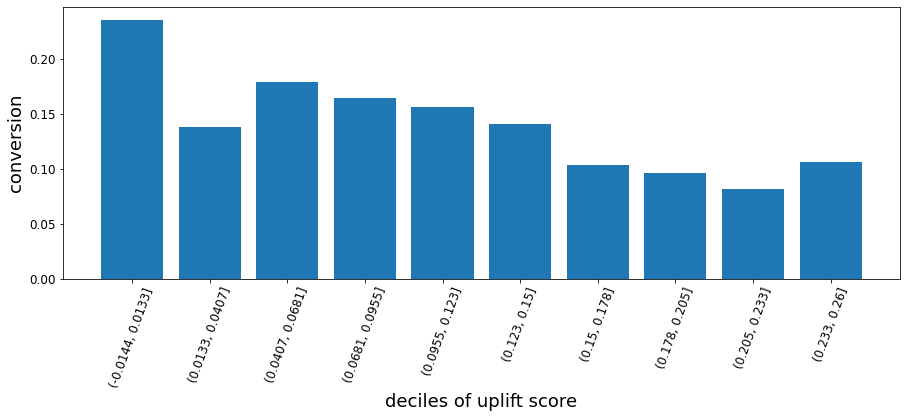

In [27]:
plt.figure(figsize=(15,5))
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
font = {'size'   : 18}

plt.rc('font', **font)
plt.bar(conversion.cut.astype('str').to_list(), conversion.conversion)
plt.xlabel('deciles of uplift score')
plt.ylabel('conversion')
plt.xticks(rotation=70)
plt.show();